In [1]:
import os, sys, csv, glob, re, warnings
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sequentia.classifiers import HMM, HMMClassifier, DTWKNN
from sequentia.preprocessing import Preprocess

# Import utility tools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from lstm import LSTMClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

seed = 0
np.random.seed(seed)
rand = np.random.RandomState(seed=seed)

In [2]:
gestures = ['nd', 'mnd', 'fu', 'fd', 'sh', 't', 'ti']

In [3]:
lag = pd.read_csv('../lag.csv', index_col=0, squeeze=True).to_dict()

In [4]:
class Recording:
    def __init__(self, csv):
        self.id = Path(csv).stem.split('.')[0]
        self.speaker = self.id.split('_')[0]
        self.personality = self.id.split('_')[-1]
        self.path = csv

class Parameters(Recording):
    def __init__(self, csv):
        super().__init__(csv)
    
    def as_df(self) -> pd.DataFrame:
        """Creates a dataframe from the rov.csv parameters file."""
        
        # Load the annotations
        df = pd.read_csv(self.path).astype(np.float64) 
        
        # Select only the rotation vectors
        df = df[['Rx', 'Ry', 'Rz']]
        
        # Add recording identifier column
        df['recording'] = self.id
        
        return df

class Annotations(Recording):
    def __init__(self, csv):
        self.params = Parameters(
            re.sub('/rov.csv', '/Normalized/rov.csv', 
                   re.sub('eaf.csv', 'rov.csv', 
                          re.sub('annotations', 'params', csv)))
        )
        super().__init__(csv)     
    
    def as_df(self) -> pd.DataFrame:
        """Creates a dataframe from the eaf.csv annotations file."""
        
        # Load the annotations
        df = pd.read_csv(self.path)   
        
        # Select the gesture type, start-time, end-time and duration columns
        df = df[['type', 'start_time', 'end_time', 'during_time']]
        
        # Rename 'during_time' column to 'duration'
        df = df.rename(columns={'type': 'gesture', 'during_time': 'duration'})
        
        # Convert the 'duration' column to an integer
        df = df.astype({'start_time': 'int32', 'end_time': 'int32', 'duration': 'int32'})

        # Convert the units from milliseconds to frames (/1000 and *100)
        df.loc[:, ['start_time', 'end_time', 'duration']] //= 10
        
        # Subtract the lag time
        df[['start_time', 'end_time']] -= round(lag[self.id] * 100)
        
        # Add recording identifier column
        df['recording'] = self.id
        
        # Reorder columns such that 'gesture' is the last column
        df = df[['start_time', 'end_time', 'duration', 'recording', 'gesture']]
        
        # Remove 'start' gestures
        df = df[df['gesture'] != 'start']
        
        return df

In [5]:
# File paths to all annotation CSV files
csvs = glob.glob('../annotations/*/eaf.csv/*.eaf.csv')

# Initialize Annotations object for each eaf.csv annotations file
anns = [Annotations(csv) for csv in csvs]
# Remove ones I annotated, without lag measure
anns = [ann for ann in anns if ann.id not in ['sophie_04_e', 'sophie_05_i']]

# Combine the parameters dataframes for each Annotations object
param_df = pd.concat(ann.params.as_df() for ann in anns)

# Combine the dataframes for each Annotations object
ann_df = pd.concat(ann.as_df() for ann in anns)

# Shuffle the annotations dataframe
ann_df = ann_df.reset_index(drop=True)

# Remove blank gestures
# NOTE: This may be caused by a larger problem, like recording misalignment - look into this!
blank_idx = []
for i, (_, gesture) in enumerate(ann_df.iterrows()):
    start, end, _, recording, _ = gesture 
    gesture_df = param_df[param_df['recording'] == recording].iloc[start:end]
    if gesture_df.empty:
        blank_idx.append(i)  
ann_df.drop(blank_idx, inplace=True)

# Split the annotations dataframe into examples and labels
ann_y = ann_df['gesture'] 
ann_X = ann_df.loc[:, ann_df.columns != 'gesture']

In [6]:
# Convert the dataframe into lists of numpy arrays
X = [param_df[param_df['recording'] == row['recording']].iloc[row['start_time']:row['end_time']][['Rx', 'Ry', 'Rz']].to_numpy() for _, row in ann_X.iterrows()]
y = list(ann_y)

In [7]:
def plot_gesture(gesture, figsize=(7, 4), title=None):
    title = 'Normalized head rotation vectors for a gesture' if title is None else title
    labels = ['X (Roll)', 'Y (Yaw)', 'Z (Pitch)']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        ax.plot(gesture[:, i], label=labels[i], color=colors[i])
        ax.legend(loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0, top=0.92)
    fig.suptitle(title)
    plt.show()

In [8]:
# Split the data into training, validation and test sets (65-20-15)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=rand)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.43, shuffle=True, random_state=rand)
print('Training set size: {}'.format(len(y_train)))
print('Validation set size: {}'.format(len(y_val)))
print('Test set size: {}'.format(len(y_test)))

Training set size: 841
Validation set size: 258
Test set size: 196


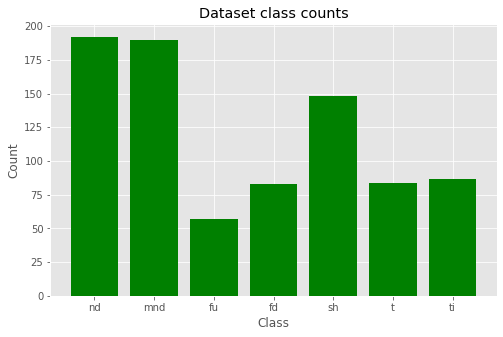

In [9]:
# Plot a chart of the class counts in the training set
show_class_counts(y_train, gestures)

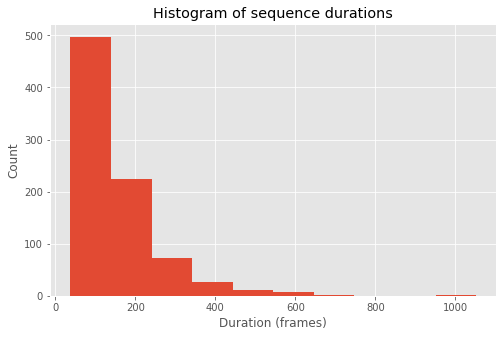

In [10]:
# Plot a histogram of gesture durations
show_durations(X_train)

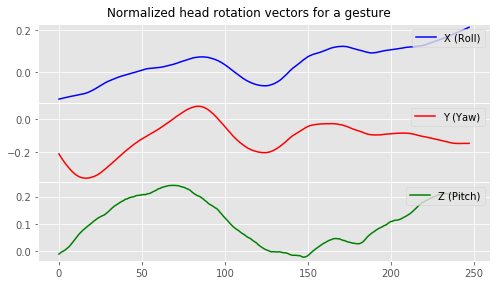

In [11]:
plot_gesture(X_train[0])

In [12]:
pre = Preprocess()
pre.filtrate(n=5, method='median')
pre.downsample(n=5, method='decimate')
pre.center()
pre.summary()

          Preprocessing summary:          
1. Filtering:
   Median filter with window size (n=5)
------------------------------------------
2. Downsampling:
   Decimation with downsample factor (n=5)
------------------------------------------
3. Centering


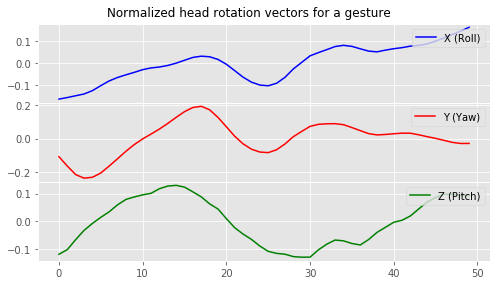

In [13]:
plot_gesture(pre.transform(X_train[0]))

In [14]:
# Transform the datasets
X_train_1, X_val_1, X_test_1 = pre.transform(X_train), pre.transform(X_val), pre.transform(X_test)

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

In [15]:
%%time

# Create HMMs to represent each class
#
# NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
# According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
# - Too many states in the HMMs
# - Too many dimensions in the input data, which leads to a large covariance matrix
# - Too few training examples
hmms = []
for g in tqdm(gestures, desc='Training HMMs'):
    hmm = HMM(label=g, n_states=7, random_state=rand)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([X_train_1[i] for i, label in enumerate(y_train) if label == g])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clf = HMMClassifier()
clf.fit(hmms)


CPU times: user 24.7 s, sys: 347 ms, total: 25 s
Wall time: 25.8 s


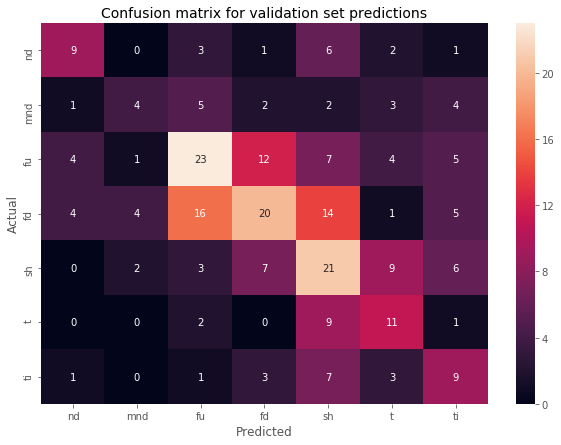

Accuracy: 37.60%
CPU times: user 628 ms, sys: 37.2 ms, total: 665 ms
Wall time: 703 ms


In [16]:
%%time
acc, cm = clf.evaluate(X_val_1, y_val)
show_results(acc, cm, dataset='validation', labels=gestures)

In [17]:
with np.printoptions(precision=3, suppress=True):
    display(hmms[0].initial)
    display(hmms[0].transitions)

array([0.095, 0.277, 0.065, 0.22 , 0.142, 0.   , 0.2  ])

array([[0.787, 0.195, 0.017, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.84 , 0.058, 0.066, 0.032, 0.   , 0.004],
       [0.   , 0.   , 0.963, 0.023, 0.   , 0.014, 0.   ],
       [0.   , 0.   , 0.   , 0.899, 0.068, 0.03 , 0.002],
       [0.   , 0.   , 0.   , 0.   , 0.937, 0.047, 0.016],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.983, 0.017],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

## DTWKNN classifier

In [18]:
# Create and fit a DTWKNN classifier using the single nearest neighbor and a radius of 1
# NOTE: The radius parameter is a parameter that constrains the FastDTW algorithm.
# clf = DTWKNN(k=1, radius=1)
# clf.fit(X_train_1, y_train)

In [19]:
# %%time
# acc, cm = clf.evaluate(X_val_1, y_val, labels=gestures, n_jobs=-1)
# show_results(acc, cm, dataset='validation', labels=gestures)

## LSTM classifier

### Preprocessing

In [20]:
from sequentia.preprocessing import filtrate, center

def lstm_pre(XX):
    XX = filtrate(XX, n=10, method='median')
    XX = smart_downsample(XX, m=50, method='decimate')
    XX = center(XX)
    return XX

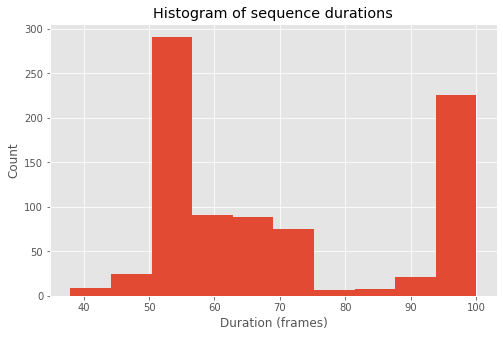

In [21]:
show_durations(lstm_pre(X_train))

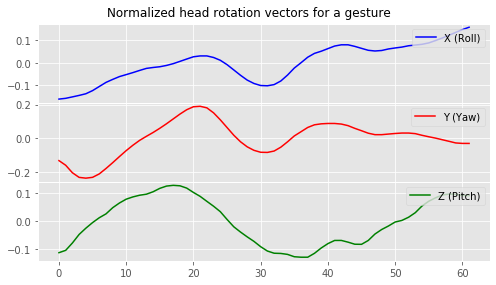

In [22]:
for gesture in lstm_pre(X_train[:1]):
    plot_gesture(gesture)

In [23]:
# Transform the datasets
X_train_lstm, X_val_lstm, X_test_lstm = lstm_pre(X_train), lstm_pre(X_val), lstm_pre(X_test)

### Fitting the model

In [32]:
%%time
from tensorflow.keras.optimizers import Adam
clf = LSTMClassifier(epochs=150, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
hist = clf.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), return_history=True)

Train on 841 samples, validate on 258 samples
Epoch 1/150
841/841 [==============================] - 5s 5ms/sample - loss: 1.9297 - accuracy: 0.2271 - val_loss: 1.8730 - val_accuracy: 0.2171
Epoch 2/150
841/841 [==============================] - 2s 3ms/sample - loss: 1.8758 - accuracy: 0.2152 - val_loss: 1.8592 - val_accuracy: 0.2171
Epoch 3/150
841/841 [==============================] - 2s 3ms/sample - loss: 1.8562 - accuracy: 0.2235 - val_loss: 1.8489 - val_accuracy: 0.2481
Epoch 4/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.8655 - accuracy: 0.2188 - val_loss: 1.8482 - val_accuracy: 0.2481
Epoch 5/150
841/841 [==============================] - 2s 3ms/sample - loss: 1.8567 - accuracy: 0.2259 - val_loss: 1.8460 - val_accuracy: 0.2442
Epoch 6/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.8533 - accuracy: 0.2497 - val_loss: 1.8452 - val_accuracy: 0.2481
Epoch 7/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.8511 

Epoch 57/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.7203 - accuracy: 0.3210 - val_loss: 1.8381 - val_accuracy: 0.2713
Epoch 58/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.7315 - accuracy: 0.2949 - val_loss: 1.8284 - val_accuracy: 0.2597
Epoch 59/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.7046 - accuracy: 0.3175 - val_loss: 1.8127 - val_accuracy: 0.2829
Epoch 60/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.6960 - accuracy: 0.3056 - val_loss: 1.8405 - val_accuracy: 0.2326
Epoch 61/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.6863 - accuracy: 0.3210 - val_loss: 1.8000 - val_accuracy: 0.2674
Epoch 62/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.7033 - accuracy: 0.3401 - val_loss: 1.8259 - val_accuracy: 0.2791
Epoch 63/150
841/841 [==============================] - 1s 2ms/sample - loss: 1.6799 - accuracy: 0.3139 - val_loss: 1.8099 -

841/841 [==============================] - 2s 2ms/sample - loss: 1.5605 - accuracy: 0.3924 - val_loss: 1.7405 - val_accuracy: 0.3527
Epoch 114/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.5034 - accuracy: 0.4031 - val_loss: 1.7591 - val_accuracy: 0.3333
Epoch 115/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.4710 - accuracy: 0.4233 - val_loss: 1.7256 - val_accuracy: 0.3411
Epoch 116/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.4232 - accuracy: 0.4400 - val_loss: 1.7395 - val_accuracy: 0.3450
Epoch 117/150
841/841 [==============================] - 2s 2ms/sample - loss: 1.4181 - accuracy: 0.4447 - val_loss: 1.7391 - val_accuracy: 0.3450
Epoch 118/150
841/841 [==============================] - 2s 3ms/sample - loss: 1.3848 - accuracy: 0.4566 - val_loss: 1.7552 - val_accuracy: 0.3411
Epoch 119/150
841/841 [==============================] - 2s 3ms/sample - loss: 1.4023 - accuracy: 0.4435 - val_loss: 1.7176 - val_ac

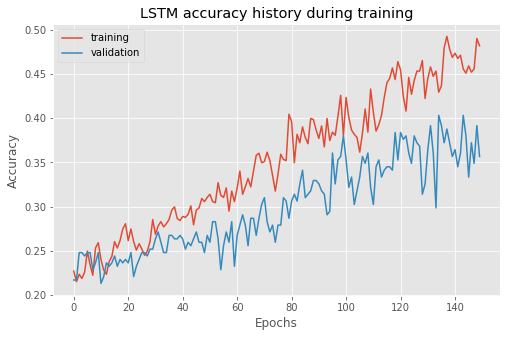

In [33]:
# Display accuracy history during training
show_accuracy_history(hist)

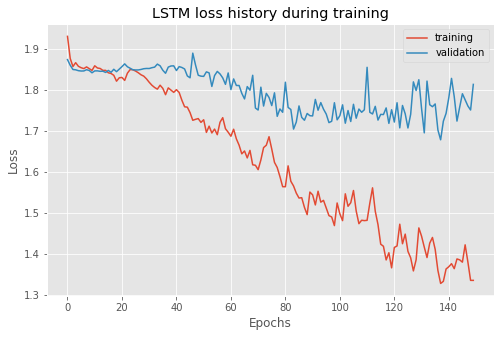

In [34]:
# Display loss history during training
show_loss_history(hist)

### Evaluating the model

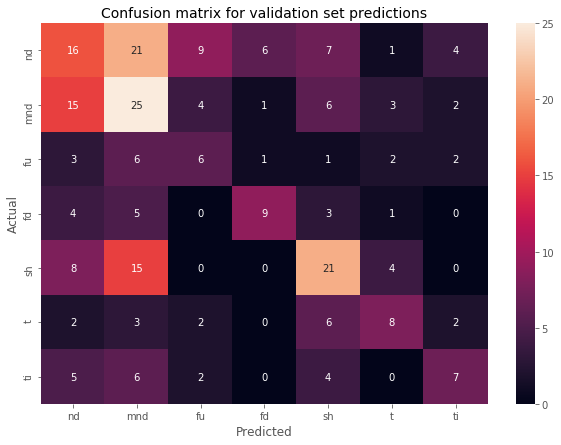

Accuracy: 35.66%
CPU times: user 1.02 s, sys: 108 ms, total: 1.13 s
Wall time: 961 ms


In [35]:
%%time
acc, cm = clf.evaluate(X_val_lstm, y_val)
show_results(acc, cm, dataset='validation', labels=gestures)